# Train and evaluate Explainers

With all these prerequisites out of the way you can now run the experiments themselves. The experiments are run for each
explanation method (T-GNNExplainer, GreDyCF, CoDy), for each dataset, for each correct/incorrect setting 
(correct predictions only/incorrect predictions only), and for each selection policy (random, temporal, spatio-temporal, 
local-gradient) separately. For convenience, all selection strategies can be automatically evaluated in parallel from a 
single script. An additional feature of the evaluation is that it can be interrupted by Keyboard Interruption or by the
maximum processing time. When the evaluation is interrupted before it is finished, the intermediary results are saved. 
The evaluation automatically resumes from intermediary results.

In [1]:
# Find and add `notebooks/src` to sys.path, no matter where the notebook lives.
from pathlib import Path
import sys, importlib
import os
import subprocess

def _add_notebooks_src_to_path():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        candidate = p / "notebooks" / "src"
        if candidate.is_dir():
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    raise FileNotFoundError("Could not find 'notebooks/src' from current working directory.")

print("Using helpers from:", _add_notebooks_src_to_path())

from constants import (
    REPO_ROOT, PKG_DIR, RESOURCES_DIR, PROCESSED_DATA_DIR, MODELS_ROOT, TGN_SUBMODULE_ROOT, ensure_repo_importable, get_last_checkpoint
)
ensure_repo_importable()
from device import pick_device

for p in (str(TGN_SUBMODULE_ROOT), str(REPO_ROOT), str(PKG_DIR)):
    if p not in sys.path:
        sys.path.insert(0, p)

# 2) If your notebook already imported `utils`, remove it to avoid collision
if "utils" in sys.modules:
    del sys.modules["utils"]

importlib.invalidate_caches()

# 4) (Optional) sanity check that TGN's local packages resolve
import importlib.util as iu
print("utils.utils   ->", iu.find_spec("utils.utils"))
print("modules.memory->", iu.find_spec("modules.memory"))

# 5) Now this import should work without the previous error
from time_to_explain.adapters import*

print("REPO_ROOT        :", REPO_ROOT)
print("PKG_DIR          :", PKG_DIR)
print("RESOURCES_DIR    :", RESOURCES_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)
print("MODELS_ROOT      :", MODELS_ROOT)

Using helpers from: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/notebooks/src
utils.utils   -> ModuleSpec(name='utils.utils', loader=<_frozen_importlib_external.SourceFileLoader object at 0x104cc9750>, origin='/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain/utils/utils.py')
modules.memory-> ModuleSpec(name='modules.memory', loader=<_frozen_importlib_external.SourceFileLoader object at 0x10829efd0>, origin='/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/models/tgn/modules/memory.py')
REPO_ROOT        : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
PKG_DIR          : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain
RESOURCES_DIR    : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources
PROCESSED_DATA_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_

## Setting:

Replace ``MODEL-TYPE`` with the type of the model you want to evaluate, e.g., 'TGAT' or 'TGN'.

Replace ``DATASET-NAME`` with the name of the dataset on which you want to train the PGExplainer model, e.g., 'uci', 
'wikipedia', etc.

Replace ``EXPLAINER-NAME`` with the explainer you want to evaluate. Options are ``tgnnexplainer``, ``greedy``, ``cody``.

Replace ``SELECTION-NAME`` with the selection policy that you want to evaluate. The options are ``random``, 
``temporal``, ``spatio-temporal``, ``local-gradient``, and ``all``. Use the ``all`` option to efficiently evaluate the
different selection strategies with caching between selection strategies.
**Do not provide a `SELECTION-NAME`` argument when evaluating T-GNNExplainer**

Replace ``TIME-LIMIT`` with an integer number that sets a limit on the maximum time that the evaluation runs before 
concluding in minutes. The evaluation can be resumed from that state at a later time.

Only set ``bipartite = True``  if the underlying dataset is a bipartite graph (Wikipedia/UCI-Forums).

As an example, to run the evaluation of CoDy for all selection strategies, with a time limit of 240 minutes and the
bipartite wikipedia dataset, the following command is used:


In [2]:
MODEL_TYPE = "TGAT"
DATASET_NAME = "wikipedia"
EXPLAINER = "cody"
SELECTION_NAME = "all"
TIME_LIMIT = 240
BIPARTITE = True

DIRECTED = False
EPOCHS = 10

MODEL_PATH = MODELS_ROOT / DATASET_NAME
CHECKPOINT_PATH = MODEL_PATH / 'checkpoints/'
if not os.path.exists(CHECKPOINT_PATH):
    os.mkdir(CHECKPOINT_PATH)
LAST_CHECKPOINT = get_last_checkpoint(CHECKPOINT_PATH,MODEL_TYPE, DATASET_NAME)    
DEVICE = pick_device("auto")
print(DEVICE)

mps


## Load Dataset and Model

In [3]:
# Core imports
import torch
from time_to_explain.data.legacy.tg_dataset import load_tg_dataset, load_explain_idx
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.dataset.utils_dataset import construct_tgat_neighbor_finder
from submodules.models.tgat.module import TGAN
from submodules.models.tgn.model.tgn import TGN
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.models.ext.tgn.utils.data_processing import compute_time_statistics

from time_to_explain.core.runner import EvaluationRunner, EvalConfig
from time_to_explain.adapters.subgraphx_tg_adapter import (
    SubgraphXTGAdapter, SubgraphXTGAdapterConfig
)
from time_to_explain.adapters.tg_model_adapter import TemporalGNNModelAdapter
from time_to_explain.extractors.tg_event_candidates_extractor import TGEventCandidatesExtractor
import time_to_explain.metrics.sparsity
import time_to_explain.metrics.fidelity

import os
import pandas as pd


Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain


In [4]:
# Notebook knobs derived from CLI settings
model_name = MODEL_TYPE.lower()
dataset_name = DATASET_NAME
ckpt_path = MODEL_PATH / 'checkpoints' / f"{model_name}_{dataset_name}_best.pth"
print('Checkpoint:', ckpt_path)


Checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models/wikipedia/checkpoints/tgat_wikipedia_best.pth


In [5]:
# Resource paths
from pathlib import Path

explain_idx_csv = str(RESOURCES_DIR / "explainer" / "explain_index" / f"{dataset_name}.csv")
ckpt_path = Path(ckpt_path)
if not ckpt_path.exists():
    ckpt_path = MODEL_PATH / 'checkpoints' / f"{model_name}_{dataset_name}_best.pth"
print('Explain index CSV:', explain_idx_csv)
print('Using checkpoint:', ckpt_path)


Explain index CSV: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/explain_index/wikipedia.csv
Using checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models/wikipedia/checkpoints/tgat_wikipedia_best.pth


In [6]:
# Load data
events, edge_feats, node_feats = load_tg_dataset(DATASET_NAME)

# Build the backbone model
if model_name == "tgat":
    ngh_finder = construct_tgat_neighbor_finder(events)
    backbone = TGAN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        attn_mode="prod",
        use_time="time",
        agg_method="attn",
        num_layers=2,
        n_head=4,
        null_idx=0,
        num_neighbors=20,
        drop_out=0.1,
    )
elif model_name == "tgn":
    m_src, s_src, m_dst, s_dst = compute_time_statistics(events.u.values, events.i.values, events.ts.values)
    ngh_finder = construct_tgat_neighbor_finder(events)   # your utils often reuse the same NF
    backbone = TGN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        n_layers=2,
        n_heads=2,
        dropout=0.1,
        use_memory=False,
        forbidden_memory_update=False,
        memory_update_at_start=True,
        message_dimension=100,
        memory_dimension=500,
        embedding_module_type="graph_attention",
        message_function="mlp",
        mean_time_shift_src=0,
        std_time_shift_src=1,
        mean_time_shift_dst=0,
        std_time_shift_dst=1,
        n_neighbors=None,
        aggregator_type="last",
        memory_updater_type="gru",
        use_destination_embedding_in_message=False,
        use_source_embedding_in_message=False,
        dyrep=False,
    )
else:
    raise NotImplementedError(model_name)

# Load backbone weights
state_dict = torch.load(ckpt_path, map_location="cpu")
_ = backbone.load_state_dict(state_dict, strict=False)
_ = backbone.to(DEVICE).eval()
print("Backbone ready on", DEVICE)
# Wrap backbone with ModelProtocol adapter (adds predict_proba & masking)
model = TemporalGNNModelAdapter(backbone, events, device=DEVICE)



#Dataset: wikipedia, #Users: 8227, #Items: 1000, #Interactions: 157474, #Timestamps: 152757
#node feats shape: (9228, 172), #edge feats shape: (157475, 172)

Backbone ready on mps


/var/folders/k7/xf0yhfbs02ggfm7n1l5g_cnm0000gn/T/ipykernel_27800/3355579743.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locat

## Build Extractor and Explainer

In [8]:
# Extractor creates a stable candidate edge order for each event (needed for fair metrics)
extractor = TGEventCandidatesExtractor(
    model=model,
    events=events,
    threshold_num=50,               # same as your SubgraphX config
    keep_order="last-N-then-sort",  # matches SubgraphX-TG's pattern
)

# Adapter wraps your existing SubgraphX‑TG with the same knobs you use in Hydra
adapter_cfg = SubgraphXTGAdapterConfig(
    model_name=model_name,
    dataset_name=dataset_name,
    explanation_level="event",
    results_dir=str(RESOURCES_DIR / "results"),
    debug_mode=False,
    threshold_num=50,
    save_results=True,
    mcts_saved_dir=str(RESOURCES_DIR / "results" / "tgnnexplainer_subgraphx" / "mcts_saved_dir" ),
    load_results=False,
    rollout=30,
    min_atoms=2,
    c_puct=10.0,
    use_navigator=False,            # set True + navigator_type ("pg"|"mlp"|"dot") if you use a navigator
    navigator_type="pg",
    navigator_params={"train_epochs": 10, "lr": 1e-3, "batch_size": 64, "explainer_ckpt_dir": str(REPO_ROOT / "xgraph" / "explainer_ckpts")},
    cache=True,
)

explainer = SubgraphXTGAdapter(adapter_cfg)


In [ ]:
# Load 1-based event indices you want to explain (same file the Hydra pipeline uses)
target_event_idxs = load_explain_idx(explain_idx_csv, start=0)

# Build anchors (we keep "target_kind" for compatibility; the crucial piece is event_idx)
N = 2  # adjust batch size if needed
anchors = [{"target_kind": "edge", "event_idx": int(e)} for e in target_event_idxs[:N]]

sparsity_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

cfg = EvalConfig(
    out_dir="runs",
    metrics={
        "sparsity": {
            "eps": 1e-6,
            "components": ["edges", "nodes"]
        },
        # fidelity-drop at predefined sparsity levels (fraction of edges removed)
        "fidelity_drop": {
            "sparsity_levels": sparsity_levels,
            "result_as_logit": True,
            "normalize": "minmax",
            "by": "value"
        },
        # sufficiency variant (keep top fraction of edges)
        "fidelity_keep": {
            "sparsity_levels": sparsity_levels,
            "result_as_logit": True
        },
        "fidelity_best": {
            "sparsity_levels": sparsity_levels,
            "result_as_logit": True
        },
    },
    seed=42
)

runner = EvaluationRunner(
    model=model,
    dataset={"events": events, "dataset_name": dataset_name},
    extractor=extractor,
    explainers=[explainer],
    config=cfg
)


100 events to explain


## Build Extractor and Explainer

In [10]:
# Extractor creates a stable candidate edge order for each event (needed for fair metrics)
extractor = TGEventCandidatesExtractor(
    model=model,
    events=events,
    threshold_num=50,               # same as your SubgraphX config
    keep_order="last-N-then-sort",  # matches SubgraphX-TG's pattern
)

# Adapter wraps your existing SubgraphX‑TG with the same knobs you use in Hydra
adapter_cfg = SubgraphXTGAdapterConfig(
    model_name=model_name,
    dataset_name=dataset_name,
    explanation_level="event",
    results_dir=str(RESOURCES_DIR / "results"),
    debug_mode=False,
    threshold_num=50,
    save_results=True,
    mcts_saved_dir=str(RESOURCES_DIR / "results" / "tgnnexplainer_subgraphx" / "mcts_saved_dir" ),
    load_results=False,
    rollout=30,
    min_atoms=2,
    c_puct=10.0,
    use_navigator=False,            # set True + navigator_type ("pg"|"mlp"|"dot") if you use a navigator
    # navigator_type="pg",
    # navigator_params={"train_epochs": 10, "lr": 1e-3, "batch_size": 64, "explainer_ckpt_dir": str(ROOT_DIR / "xgraph" / "explainer_ckpts")},
    cache=True,
)

explainer = SubgraphXTGAdapter(adapter_cfg)


## Run Evaluation

In [11]:
# Execution knobs
USE_CACHED_RESULTS = True

#### Run

In [ ]:
from pathlib import Path

def _ensure_int_attr(obj, primary, alt_names, fallback):
    val = getattr(obj, primary, None)
    if val is None:
        for n in alt_names:
            v2 = getattr(obj, n, None)
            if v2 is not None:
                val = v2
                break
    if val is None:
        val = fallback
    try:
        setattr(obj, primary, int(val))
    except Exception:
        setattr(obj, primary, fallback)

# align model attributes for extractor defaults
_ensure_int_attr(model, "num_layers", ["n_layers"], 2)
_ensure_int_attr(model, "num_neighbors", ["n_neighbors"], 20)

levels = cfg.metrics.get("fidelity_drop", {}).get("sparsity_levels", [])
level_signature = '-'.join(f"{lvl:.2f}" for lvl in levels) if levels else 'none'
run_id = f"{model_name}_{dataset_name}_{explainer.alias}_s{level_signature}_{len(anchors)}anchors"

out_dir = Path(cfg.out_dir) / run_id
csv_path = out_dir / "metrics.csv"
jsonl_path = out_dir / "results.jsonl"

if USE_CACHED_RESULTS and csv_path.exists():
    print(f"Reusing cached explanations from {csv_path}")
    out = {
        "out_dir": str(out_dir),
        "csv": str(csv_path),
        "jsonl": str(jsonl_path) if jsonl_path.exists() else None,
    }
else:
    out = runner.run(
        anchors,
        k_hop=getattr(model, "num_layers", 2) or 2,
        num_neighbors=getattr(model, "num_neighbors", 20) or 20,
        run_id=run_id,
    )
    print(f"Stored new explanations under {out['out_dir']}")
out



explain 0-th: 110314

The nodes in graph is 146


mcts simulating: 100%|██████████| 30/30 [00:17<00:00,  1.74it/s, states=838]


mcts recorder saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/candidate_scores/tgat_wikipedia_110314_mcts_recorder_pg_false_th50.csv
results saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/tgnnexplainer_subgraphx/mcts_saved_dir/tgat_wikipedia_110314_mcts_node_info_pg_false_th50.pt

explain 1-th: 110832

The nodes in graph is 488


mcts simulating: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it, states=838]


mcts recorder saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/candidate_scores/tgat_wikipedia_110832_mcts_recorder_pg_false_th50.csv
results saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/tgnnexplainer_subgraphx/mcts_saved_dir/tgat_wikipedia_110832_mcts_node_info_pg_false_th50.pt

explain 2-th: 111397

The nodes in graph is 447


mcts simulating:  20%|██        | 6/30 [04:10<21:46, 54.43s/it, states=178]

In [ ]:
# Utility: load multiple metrics tables and plot fidelity vs. sparsity
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def read_tabs_plot(files, name, plot_only_og=False, *,
                   metric='fidelity_best.best',
                   sparsity_col='sparsity.edges.zero_frac',
                   labels=None, markers=None, palette='deep',
                   og_keys=None, save_dir='plots'):
    """Load metric CSVs, aggregate by sparsity, and plot fidelity curves."""
    files = {k: os.fspath(v) for k, v in files.items()}
    sns.set_theme(style='whitegrid')

    tabs = {}
    best_fids = {}
    aufsc = {}

    for key, path in files.items():
        df = pd.read_csv(path)
        if sparsity_col in df:
            sparsity = df[sparsity_col]
        elif 'sparsity' in df:
            sparsity = df['sparsity']
        else:
            raise KeyError(f"{sparsity_col!r} column not found in {path}")

        if metric not in df:
            raise KeyError(f"Metric column {metric!r} not found in {path}")

        tab = (df
               .assign(sparsity=sparsity)
               .groupby('sparsity', as_index=False)[metric]
               .mean()
               .sort_values('sparsity'))
        tabs[key] = tab

        best_fids[key] = tab[metric].max()
        aufsc[key] = float(np.trapz(tab[metric], tab['sparsity']))

    print('Best Fidelity (max across levels):', best_fids)
    print('Area under fidelity-sparsity curve:', aufsc)

    og_defaults = set(og_keys or ['xtg-og', 'attn', 'pbone', 'pg'])
    keys_to_plot = [k for k in tabs if (not plot_only_og or k in og_defaults)]
    if not keys_to_plot:
        keys_to_plot = list(tabs.keys())

    os.makedirs(save_dir, exist_ok=True)
    palette_colors = sns.color_palette(palette, len(keys_to_plot))
    default_markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']

    fig, ax = plt.subplots(figsize=(8, 4))
    for idx, key in enumerate(keys_to_plot):
        tab = tabs[key]
        label = (labels or {}).get(key, key)
        marker = (markers or {}).get(key, default_markers[idx % len(default_markers)])
        sns.lineplot(data=tab, x='sparsity', y=metric, ax=ax,
                     label=label, color=palette_colors[idx], marker=marker)

    ax.set_xlabel('Sparsity (fraction of zero edges)')
    ax.set_ylabel(metric)
    ax.set_title(f'Fidelity vs sparsity — {name}')
    ax.legend()
    fig.tight_layout()

    out_path = os.path.join(save_dir, f'{name}.png')
    fig.savefig(out_path, dpi=200)
    plt.show()

    return tabs, best_fids, aufsc


## Inspect Results and Metrics

### Fidelity metrics
For each explanation we log:
- `fidelity_drop.prediction_full`: model score on the full candidate subgraph.
- `fidelity_drop.prediction_drop.@s=p`: score after dropping the top fraction `p` of edges (aligned with the extractor's candidate order).
- `fidelity_drop.@s=p`: absolute change `|prediction_full - prediction_drop.@s=p|`.
- `fidelity_best.best`: maximum absolute change across the configured sparsity levels (`fidelity_best.best.k` shows the level).

The keep variant mirrors this with `prediction_keep.@s=p` and `fidelity_keep.@s=p` (keeping the top fraction `p`).

Loaded metrics from runs/tgn_wikipedia_tgnnexplainer_subgraphx/metrics.csv
Rows: 3, Columns: 37
=== fidelity_best ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_best.prediction_full,fidelity_best.prediction_drop.@6,fidelity_best.prediction_drop.@12,fidelity_best.prediction_drop.@18,fidelity_best.@6,fidelity_best.@12,fidelity_best.@18,fidelity_best.best,fidelity_best.best.k
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.983084,0.935331,0.972041,0.986843,0.047753,0.011043,0.003759,0.047753,6.0
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.993409,0.997390,0.997399,0.997401,0.003981,0.003990,0.003992,0.003992,18.0
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.996358,0.996821,0.997389,0.996200,0.000462,0.001030,0.000158,0.001030,12.0


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_best.prediction_full,fidelity_best.prediction_drop.@6,fidelity_best.prediction_drop.@12,fidelity_best.prediction_drop.@18,fidelity_best.@6,fidelity_best.@12,fidelity_best.@18,fidelity_best.best,fidelity_best.best.k
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.983084,0.935331,0.972041,0.986843,0.047753,0.011043,0.003759,0.047753,6.0
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.993409,0.997390,0.997399,0.997401,0.003981,0.003990,0.003992,0.003992,18.0
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.996358,0.996821,0.997389,0.996200,0.000462,0.001030,0.000158,0.001030,12.0


=== fidelity_drop ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_drop.prediction_full,fidelity_drop.prediction_drop.@6,fidelity_drop.prediction_drop.@12,fidelity_drop.prediction_drop.@18,fidelity_drop.@6,fidelity_drop.@12,fidelity_drop.@18
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.983084,0.935331,0.972041,0.986843,0.047753,0.011043,0.003759
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.993409,0.997390,0.997399,0.997401,0.003981,0.003990,0.003992
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.996358,0.996821,0.997389,0.996200,0.000462,0.001030,0.000158


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_drop.prediction_full,fidelity_drop.prediction_drop.@6,fidelity_drop.prediction_drop.@12,fidelity_drop.prediction_drop.@18,fidelity_drop.@6,fidelity_drop.@12,fidelity_drop.@18
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.983084,0.935331,0.972041,0.986843,0.047753,0.011043,0.003759
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.993409,0.997390,0.997399,0.997401,0.003981,0.003990,0.003992
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.996358,0.996821,0.997389,0.996200,0.000462,0.001030,0.000158


=== fidelity_keep ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_keep.prediction_full,fidelity_keep.prediction_keep.@6,fidelity_keep.prediction_keep.@12,fidelity_keep.prediction_keep.@18,fidelity_keep.@6,fidelity_keep.@12,fidelity_keep.@18
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.983084,0.346144,0.813248,0.803670,0.636940,0.169836,0.179414
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.993409,0.371453,0.226732,0.195011,0.621956,0.766677,0.798398
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.996358,0.890276,0.786143,0.631153,0.106083,0.210216,0.365205


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_keep.prediction_full,fidelity_keep.prediction_keep.@6,fidelity_keep.prediction_keep.@12,fidelity_keep.prediction_keep.@18,fidelity_keep.@6,fidelity_keep.@12,fidelity_keep.@18
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.983084,0.346144,0.813248,0.803670,0.636940,0.169836,0.179414
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.993409,0.371453,0.226732,0.195011,0.621956,0.766677,0.798398
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.996358,0.890276,0.786143,0.631153,0.106083,0.210216,0.365205


=== sparsity ===


,anchor_idx,explainer,run_id,elapsed_sec,sparsity.edges.density,sparsity.edges.entropy,sparsity.edges.gini,sparsity.edges.l0,sparsity.edges.mean,sparsity.edges.n,sparsity.edges.std,sparsity.edges.zero_frac,sparsity.nodes.l0,sparsity.nodes.n
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.04,0.693147,0.94,48,0.04,50,0.195959,0.96,0,0
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.04,0.693147,0.94,48,0.04,50,0.195959,0.96,0,0
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.04,0.693147,0.94,48,0.04,50,0.195959,0.96,0,0


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,sparsity.edges.density,sparsity.edges.entropy,sparsity.edges.gini,sparsity.edges.l0,sparsity.edges.mean,sparsity.edges.n,sparsity.edges.std,sparsity.edges.zero_frac,sparsity.nodes.l0,sparsity.nodes.n
0,0,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.227035,0.04,0.693147,0.94,48.0,0.04,50.0,0.195959,0.96,0.0,0.0
1,1,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.116522,0.04,0.693147,0.94,48.0,0.04,50.0,0.195959,0.96,0.0,0.0
2,2,subgraphx_tg_tgn,tgn_wikipedia_tgnnexplainer_subgraphx,15.354811,0.04,0.693147,0.94,48.0,0.04,50.0,0.195959,0.96,0.0,0.0


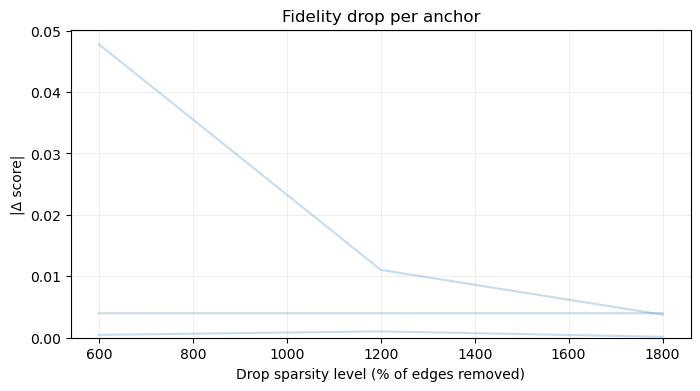

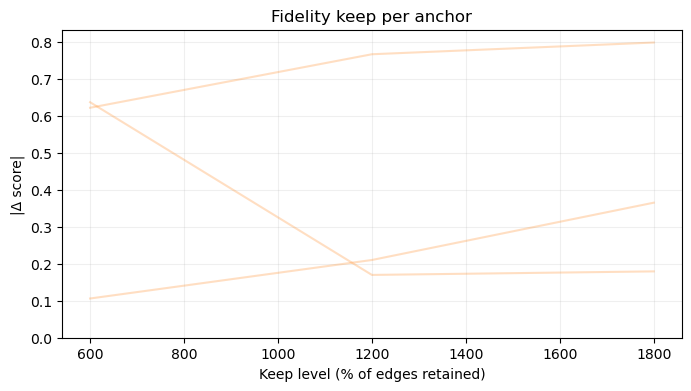

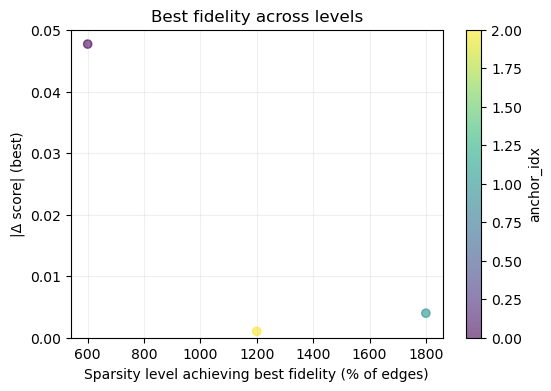

In [ ]:
# Metrics overview grouped by metric name
import pandas as pd
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import numbers

metrics_path = out["csv"]
metrics_df = pd.read_csv(metrics_path)
print(f"Loaded metrics from {metrics_path}")
print(f"Rows: {len(metrics_df)}, Columns: {len(metrics_df.columns)}")

context_cols = [c for c in ("anchor_idx", "explainer", "run_id", "elapsed_sec") if c in metrics_df.columns]

metric_groups = defaultdict(list)
for col in metrics_df.columns:
    metric_name, sep, remainder = col.partition('.')
    if not sep:
        continue
    metric_groups[metric_name].append(col)

metric_summary = {}
for metric_name, cols in metric_groups.items():
    metric_cols = [c for c in cols if c in metrics_df.columns]
    if not metric_cols:
        continue
    if context_cols:
        agg = metrics_df.groupby(context_cols, dropna=False)[metric_cols].mean().reset_index()
    else:
        agg = pd.DataFrame({metric_name: metrics_df[metric_cols].mean()}).T
    metric_summary[metric_name] = agg

def _parse_suffix(token: str):
    if token.startswith('s='):
        try:
            return float(token.split('=', 1)[1])
        except ValueError:
            return token
    try:
        return float(token)
    except ValueError:
        return token

def column_order(col: str):
    _, _, remainder = col.partition('.')
    if remainder == 'prediction_full':
        return (0, 0, 0)
    if remainder.startswith('prediction_') and '.@' in remainder:
        mode_part, _, suffix = remainder.partition('.@')
        suffix_val = _parse_suffix(suffix)
        mode_rank = {'prediction_drop': 0, 'prediction_keep': 1}.get(mode_part, 2)
        return (1, mode_rank, suffix_val)
    if remainder.startswith('@'):
        suffix_val = _parse_suffix(remainder[1:])
        return (2, 0, suffix_val)
    if remainder == 'best':
        return (3, 0, 0)
    if remainder == 'best.k':
        return (3, 1, 0)
    return (4, remainder, 0)

for metric_name in sorted(metric_groups):
    cols = sorted(set(metric_groups[metric_name]), key=column_order)
    shown = context_cols + [c for c in cols if c in metrics_df.columns]
    if len(shown) <= len(context_cols):
        continue
    print(f"=== {metric_name} ===")
    display(metrics_df[shown].sort_values(by=[c for c in shown if c not in context_cols]))
    summary = metric_summary.get(metric_name)
    if summary is not None and not summary.empty:
        print('Average across groups:')
        summary_cols = [c for c in context_cols if c in summary.columns] + [c for c in cols if c in summary.columns]
        display(summary[summary_cols])

def _collect_curve(prefix: str):
    cols = [c for c in metrics_df.columns if c.startswith(prefix) and '@' in c and not c.endswith('.k')]
    cols_sorted = sorted(cols, key=lambda c: _parse_suffix(c.split('@', 1)[1]))
    xs = [_parse_suffix(c.split('@', 1)[1]) for c in cols_sorted]
    return cols_sorted, xs

def _levels_to_axis(levels):
    axis_vals = []
    fractional = False
    for lvl in levels:
        if isinstance(lvl, numbers.Real):
            lvl_float = float(lvl)
            if np.isnan(lvl_float) or np.isinf(lvl_float):
                axis_vals.append(lvl_float)
                continue
            if 0.0 <= lvl_float <= 1.0:
                axis_vals.append(lvl_float * 100.0)
                fractional = True
            else:
                axis_vals.append(lvl_float)
        else:
            axis_vals.append(lvl)
    return axis_vals, fractional

fidelity_drop_cols, drop_levels = _collect_curve('fidelity_drop.@')
fidelity_keep_cols, keep_levels = _collect_curve('fidelity_keep.@')

if fidelity_drop_cols:
    drop_axis, drop_is_fractional = _levels_to_axis(drop_levels)
    fig, ax = plt.subplots(figsize=(8, 4))
    for _, row in metrics_df.iterrows():
        y_vals = [row.get(col, np.nan) for col in fidelity_drop_cols]
        ax.plot(drop_axis, y_vals, color='tab:blue', alpha=0.25)
    ax.set_title('Fidelity drop per anchor')
    xlabel = 'Drop sparsity level (% of edges removed)' if drop_is_fractional else 'Drop level (top-k edges removed)'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('|Δ score|')
    ax.set_ylim(bottom=0.0)
    ax.grid(True, alpha=0.2)
    plt.show()

if fidelity_keep_cols:
    keep_axis, keep_is_fractional = _levels_to_axis(keep_levels)
    fig, ax = plt.subplots(figsize=(8, 4))
    for _, row in metrics_df.iterrows():
        y_vals = [row.get(col, np.nan) for col in fidelity_keep_cols]
        ax.plot(keep_axis, y_vals, color='tab:orange', alpha=0.25)
    ax.set_title('Fidelity keep per anchor')
    xlabel = 'Keep level (% of edges retained)' if keep_is_fractional else 'Keep level (top-k edges retained)'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('|Δ score|')
    ax.set_ylim(bottom=0.0)
    ax.grid(True, alpha=0.2)
    plt.show()

if 'fidelity_best.best' in metrics_df.columns:
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = metrics_df['anchor_idx'] if 'anchor_idx' in metrics_df.columns else np.arange(len(metrics_df))
    levels = metrics_df['fidelity_best.best.k'] if 'fidelity_best.best.k' in metrics_df.columns else np.full(len(metrics_df), np.nan)
    level_values = levels.tolist() if hasattr(levels, 'tolist') else list(levels)
    best_axis, best_is_fractional = _levels_to_axis(level_values)
    x_vals = np.array(best_axis, dtype=float)
    y_vals = metrics_df['fidelity_best.best']
    scatter = ax.scatter(x_vals, y_vals, c=colors, cmap='viridis', alpha=0.6)
    ax.set_title('Best fidelity across levels')
    xlabel = 'Sparsity level achieving best fidelity (% of edges)' if best_is_fractional else 'Top-k achieving best fidelity'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('|Δ score| (best)')
    ax.set_ylim(bottom=0.0)
    ax.grid(True, alpha=0.2)
    if scatter.get_offsets().size > 0:
        label = 'anchor_idx' if 'anchor_idx' in metrics_df.columns else 'row index'
        plt.colorbar(scatter, label=label, ax=ax)
    plt.show()



In [ ]:
# Basic sanity checks to make sure metric outputs look reasonable
import numpy as np
import re

if metrics_df.empty:
    raise RuntimeError("metrics_df is empty; nothing to evaluate.")

fidelity_cols = [c for c in metrics_df.columns if c.startswith("fidelity_")]
sparsity_cols = [c for c in metrics_df.columns if "sparsity" in c]

summary = {}

# Fidelity checks
fid_arrays = []
for col in fidelity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite = vals[np.isfinite(vals)]
    if finite.size == 0:
        raise RuntimeError(f"{col} has no finite values (all NaN/inf).")
    fid_arrays.append(finite)
    frac_nan = 1.0 - (finite.size / max(1, vals.size))
    if frac_nan > 0:
        print(f"⚠️  {col}: {frac_nan:.1%} of values were NaN and were dropped from sanity checks.")

if fid_arrays:
    all_fid = np.concatenate(fid_arrays)
    summary["fidelity"] = {
        "mean": float(all_fid.mean()),
        "std": float(all_fid.std()),
        "min": float(all_fid.min()),
        "max": float(all_fid.max()),
    }
else:
    print("No fidelity_* columns present; skipping fidelity sanity checks.")

# Sparsity checks (should live in [0, 1])
ratio_suffixes = (".zero_frac", ".density")
count_suffixes = (".n", ".l0")

for col in sparsity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite_mask = np.isfinite(vals)
    finite = vals[finite_mask]
    if finite.size == 0:
        print(f"⚠️  {col}: all values are NaN/inf; skipping.")
        continue
    suffix = next((s for s in ratio_suffixes + count_suffixes if col.endswith(s)), None)
    if suffix in count_suffixes:
        if (finite < -1e-6).any():
            raise RuntimeError(f"{col} contains negative counts: min={finite.min():.3f}")
        summary.setdefault("sparsity_counts", {})[col] = float(finite.mean())
        continue
    if suffix in ratio_suffixes:
        if (finite < -1e-6).any() or (finite > 1 + 1e-6).any():
            raise RuntimeError(
                f"{col} contains values outside [0, 1]: min={finite.min():.3f}, max={finite.max():.3f}"
            )
        summary.setdefault("sparsity", {})[col] = float(finite.mean())
        continue
    summary.setdefault("sparsity_misc", {})[col] = float(finite.mean())
    missing_frac = 1.0 - (finite.size / max(1, vals.size))
    if missing_frac > 0:
        print(f"⚠️  {col}: skipped {missing_frac:.1%} missing values.")

# Monotonicity checks for fidelity series (per row)
trend_expectations = {
    "fidelity_drop": ("non_decreasing", "Removing more edges should not reduce the drop in score."),
    "fidelity_keep": ("non_decreasing", "Keeping more edges should not reduce coverage (expect absolute change grows)."),
}
pattern = re.compile(r"^(fidelity_(?:drop|keep))\.@(.*)")
violations = []

for prefix, (expect, desc) in trend_expectations.items():
    prefix_cols = [c for c in fidelity_cols if c.startswith(prefix + ".@")]
    if not prefix_cols:
        continue
    # sort columns by sparsity level
    col_info = []
    for col in prefix_cols:
        m = pattern.match(col)
        if not m:
            continue
        level = m.group(2)
        try:
            level_val = float(level.split('=')[1]) if level.startswith('s=') else float(level)
        except ValueError:
            continue
        col_info.append((level_val, col))
    col_info.sort()
    if not col_info:
        continue

    for row_idx in metrics_df.index:
        values = []
        for lvl, col in col_info:
            val = metrics_df.at[row_idx, col]
            if val is None:
                continue
            try:
                val_f = float(val)
            except (TypeError, ValueError):
                continue
            if not np.isfinite(val_f):
                continue
            values.append((lvl, val_f))
        if len(values) < 2:
            continue
        values.sort()
        seq = np.array([v for _, v in values], dtype=float)
        diffs = np.diff(seq)
        tol = 1e-6
        if expect == "non_decreasing" and np.any(diffs < -tol):
            violations.append((prefix, row_idx, [lvl for lvl, _ in values], seq.tolist(), desc))

if violations:
    lines = ["Fidelity monotonicity check failed for the following rows:"]
    for prefix, row_idx, lvls, seq, desc in violations[:5]:
        anchor = metrics_df.at[row_idx, "anchor_idx"] if "anchor_idx" in metrics_df.columns else row_idx
        expl = metrics_df.at[row_idx, "explainer"] if "explainer" in metrics_df.columns else "?"
        lines.append(
            f"  [{prefix}] row={row_idx} (anchor={anchor}, explainer={expl}): levels={lvls} values={seq} :: {desc}"
        )
    print("\n".join(lines))


Fidelity monotonicity check failed for the following rows:
  [fidelity_keep] row=0 (anchor=0, explainer=subgraphx_tg_tgn): ks=[6, 12, 18] values=[0.6369396716478828, 0.1698360988847915, 0.1794140770786234] :: Keeping more edges should not increase the drop in score.
  [fidelity_keep] row=1 (anchor=1, explainer=subgraphx_tg_tgn): ks=[6, 12, 18] values=[0.6219558113796256, 0.7666771465682881, 0.7983978901267827] :: Keeping more edges should not increase the drop in score.
  [fidelity_keep] row=2 (anchor=2, explainer=subgraphx_tg_tgn): ks=[6, 12, 18] values=[0.1060826576091397, 0.2102158365633641, 0.3652049407212189] :: Keeping more edges should not increase the drop in score.


In [ ]:
print("Metric sanity summary:")
for key, val in summary.items():
    print(f"  {key}: {val}")

Metric sanity summary:
  fidelity: {'mean': 1.040519618094882, 'std': 2.58588439166882, 'min': 0.0001584818938256, 'max': 18.0}
  sparsity_counts: {'sparsity.edges.n': 50.0, 'sparsity.edges.l0': 48.0, 'sparsity.nodes.n': 0.0, 'sparsity.nodes.l0': 0.0}
  sparsity: {'sparsity.edges.zero_frac': 0.96, 'sparsity.edges.density': 0.04}
  sparsity_misc: {'sparsity.edges.gini': 0.94, 'sparsity.edges.entropy': 0.6931471805599453, 'sparsity.edges.mean': 0.04, 'sparsity.edges.std': 0.1959591794226542}
